In [2]:
!apt-get update
!apt-get install -y swig cmake

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,844 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,244 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-securi

In [3]:
!pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.0 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351180 sha256=46f47aeda96026150030f5b345daabc332f9d0847ad594d2e44ee9f1ec669e25
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [4]:
env_configs = {
    "Acrobot-v1": {
        "num_episodes": 1000,
        "max_timesteps_per_episode": 500,
        "target_reward": -100, 
        "gamma": 0.99,
        "lam": 0.95,
        "lr": 5e-4,  
        "batch_size": 32,
        "update_epochs": 3,
        "epsilon": 0.2,
        "entropy_coef": 0.01
    },
    "CartPole-v1": {
        "num_episodes": 2000,
        "max_timesteps_per_episode": 500,
        "target_reward": 475,
        "gamma": 0.99,
        "lam": 0.95,
        "lr": 1e-3,  
        "batch_size": 32,
        "update_epochs": 3,
        "epsilon": 0.1,  
        "entropy_coef": 0.05
    },
    "BipedalWalker-v3": {
        "num_episodes": 2000,
        "max_timesteps_per_episode": 1600,
        "target_reward": 300,
        "gamma": 0.99,
        "lam": 0.95,
        "lr": 3e-4,
        "batch_size": 64,
        "update_epochs": 5,
        "epsilon": 0.2,
        "entropy_coef": 0.01
    }
}

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, action_space, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.action_space = action_space 
        
        if isinstance(action_space, gym.spaces.Discrete):
            self.fc3 = nn.Linear(hidden_dim, output_dim)
        elif isinstance(action_space, gym.spaces.Box):  
            self.mu = nn.Linear(hidden_dim, output_dim) 
            self.log_std = nn.Parameter(torch.zeros(output_dim))

        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=0.01)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))

        if hasattr(self, 'fc3'): 
            action_probs = F.softmax(self.fc3(x), dim=-1)
            return action_probs
        else:  
            mu = torch.tanh(self.mu(x)) 
            if isinstance(self.action_space, gym.spaces.Box):
                mu = mu * torch.FloatTensor(self.action_space.high).to(device)

            std = torch.exp(self.log_std).expand_as(mu)
            return mu, std

class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=1.0)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        return self.fc3(x)

class PPO:
    def __init__(self, env, actor, critic, gamma=0.99, lam=0.95, epsilon=0.2,
                 lr=3e-4, batch_size=64, update_epochs=10, entropy_coef=0.01,
                 value_coef=0.5, max_grad_norm=0.5):
        self.env = env
        self.actor = actor
        self.critic = critic
        self.gamma = gamma
        self.lam = lam  
        self.epsilon = epsilon
        self.lr = lr  
        self.batch_size = batch_size 
        self.update_epochs = update_epochs 
        self.entropy_coef = entropy_coef  
        self.value_coef = value_coef  
        self.max_grad_norm = max_grad_norm

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr)

        self.scheduler_actor = optim.lr_scheduler.StepLR(self.optimizer_actor, step_size=100, gamma=0.9)
        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer_critic, step_size=100, gamma=0.9)

        self.training_stats = {
            'actor_losses': [],
            'critic_losses': [],
            'entropy_values': [],
            'approx_kl_divs': []
        }

    def compute_gae(self, rewards, values, next_value, dones):
        gae = 0
        returns = []
        advantages = []

        for i in reversed(range(len(rewards))):
            if i == len(rewards) - 1:
                next_val = next_value
            else:
                next_val = values[i + 1]

            delta = rewards[i] + self.gamma * next_val * (1 - dones[i]) - values[i]

            gae = delta + self.gamma * self.lam * (1 - dones[i]) * gae

            advantages.insert(0, gae)
            returns.insert(0, gae + values[i])

        return returns, advantages

    def select_action(self, state):
        state = np.array(state)
        state = torch.FloatTensor(state).to(device)
        
        with torch.no_grad():
            if isinstance(self.env.action_space, gym.spaces.Discrete):
                action_probs = self.actor(state)
                dist = torch.distributions.Categorical(probs=action_probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
                action = action.item()
            else:
                mu, std = self.actor(state)
                dist = torch.distributions.Normal(mu, std)
                action = dist.sample()
                log_prob = dist.log_prob(action).sum()
                action = action.cpu().numpy()

        return action, log_prob

    def evaluate_actions(self, states, actions):
        if isinstance(self.env.action_space, gym.spaces.Discrete):
            action_probs = self.actor(states)
            dist = torch.distributions.Categorical(probs=action_probs)
            log_probs = dist.log_prob(actions)
            entropy = dist.entropy()
        else:
            mu, std = self.actor(states)
            dist = torch.distributions.Normal(mu, std)
            actions_tensor = actions if isinstance(actions, torch.Tensor) else torch.FloatTensor(actions).to(device)
            log_probs = dist.log_prob(actions_tensor).sum(1)
            entropy = dist.entropy().sum(1)

        values = self.critic(states).squeeze()

        return log_probs, values, entropy

    def update_policy(self, states, actions, old_log_probs, returns, advantages):
        states = torch.FloatTensor(states).to(device)

        if isinstance(self.env.action_space, gym.spaces.Discrete):
            actions = torch.LongTensor(actions).to(device)
        else:
            actions = torch.FloatTensor(actions).to(device)

        old_log_probs = torch.FloatTensor(old_log_probs).to(device)
        returns = torch.FloatTensor(returns).to(device)
        advantages = torch.FloatTensor(advantages).to(device)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.update_epochs):
            indices = torch.randperm(len(states))

            for start in range(0, len(states), self.batch_size):
                idx = indices[start:start + self.batch_size]

                mb_states = states[idx]
                mb_actions = actions[idx]
                mb_old_log_probs = old_log_probs[idx]
                mb_returns = returns[idx]
                mb_advantages = advantages[idx]

                new_log_probs, values, entropy = self.evaluate_actions(mb_states, mb_actions)

                ratio = torch.exp(new_log_probs - mb_old_log_probs)

                surrogate1 = ratio * mb_advantages
                surrogate2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * mb_advantages

                actor_loss = -torch.min(surrogate1, surrogate2).mean()
                entropy_loss = -entropy.mean()
                actor_loss += self.entropy_coef * entropy_loss

                value_loss = F.mse_loss(values, mb_returns)

                with torch.no_grad():
                    log_ratio = new_log_probs - mb_old_log_probs
                    approx_kl_div = ((torch.exp(log_ratio) - 1) - log_ratio).mean().item()
                    self.training_stats['approx_kl_divs'].append(approx_kl_div)

                self.training_stats['actor_losses'].append(actor_loss.item())
                self.training_stats['critic_losses'].append(value_loss.item())
                self.training_stats['entropy_values'].append(entropy_loss.item())

                self.optimizer_actor.zero_grad()
                actor_loss.backward()
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                self.optimizer_actor.step()

                self.optimizer_critic.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.optimizer_critic.step()

    def train(self, num_episodes=1000, max_timesteps_per_episode=1000, target_reward=None, window_size=100):
        episode_rewards = []
        avg_rewards = []
        best_avg_reward = -float('inf')
        solved = False

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            episode_reward = 0

            states = []
            actions = []
            log_probs = []
            rewards = []
            dones = []
            values = []

            for t in range(max_timesteps_per_episode):
                with torch.no_grad():
                    value = self.critic(torch.FloatTensor(state).to(device)).item()

                action, log_prob = self.select_action(state)

                states.append(state)
                values.append(value)
                actions.append(action)
                log_probs.append(log_prob)

                next_state, reward, terminated, truncated, _ = self.env.step(action)

                done = terminated or truncated

                rewards.append(reward)
                dones.append(done)

                state = next_state
                episode_reward += reward

                if done:
                    break

            with torch.no_grad():
                last_value = self.critic(torch.FloatTensor(state).to(device)).item()

            returns, advantages = self.compute_gae(rewards, values, last_value, dones)

            self.update_policy(states, actions, [lp.item() for lp in log_probs], returns, advantages)

            episode_rewards.append(episode_reward)

            self.scheduler_actor.step()
            self.scheduler_critic.step()

            if len(episode_rewards) >= window_size:
                avg_reward = np.mean(episode_rewards[-window_size:])
                avg_rewards.append(avg_reward)

                if avg_reward > best_avg_reward:
                    best_avg_reward = avg_reward
                    torch.save({
                        'actor_state_dict': self.actor.state_dict(),
                        'critic_state_dict': self.critic.state_dict(),
                    }, f'{self.env.unwrapped.spec.id}_ppo_best.pt')

                if target_reward is not None and avg_reward >= target_reward and not solved:
                    print(f"\n🎉 Environment solved in {episode+1} episodes! Average reward: {avg_reward:.2f}")
                    solved = True
            else:
                avg_rewards.append(np.mean(episode_rewards))

            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{num_episodes} | Reward: {episode_reward:.2f} | Avg Reward: {avg_rewards[-1]:.2f}")

                if (episode + 1) % 50 == 0 and self.training_stats['actor_losses']:
                    print(f"Actor Loss: {np.mean(self.training_stats['actor_losses'][-50:]):.4f} | "
                          f"Critic Loss: {np.mean(self.training_stats['critic_losses'][-50:]):.4f} | "
                          f"Entropy: {-np.mean(self.training_stats['entropy_values'][-50:]):.4f} | "
                          f"Approx KL: {np.mean(self.training_stats['approx_kl_divs'][-50:]):.4f}")

        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
        }, f'{self.env.unwrapped.spec.id}_ppo_final.pt')

        return episode_rewards, avg_rewards

def evaluate_agent(env, actor, num_episodes=10):
    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0

        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                if isinstance(env.action_space, gym.spaces.Discrete):
                    probs = actor(state_tensor)
                    action = torch.argmax(probs).item()
                else:
                    mu, _ = actor(state_tensor)
                    action = mu.cpu().numpy()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)

    avg_reward = np.mean(total_rewards)
    print(f"\nEvaluation over {num_episodes} episodes: {avg_reward:.2f}")
    return avg_reward

def plot_training_results(rewards, avg_rewards, env_name, target_reward=None, window_size=100):
    plt.figure(figsize=(12, 6))

    plt.plot(rewards, alpha=0.6, label='Episode Rewards')

    plt.plot(avg_rewards, label=f'Moving Average ({window_size} episodes)', color='red')

    if target_reward is not None:
        plt.axhline(y=target_reward, color='green', linestyle='--', label=f'Target Reward: {target_reward}')

    plt.title(f'Training Results - {env_name}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig(f'{env_name}_training_results.png')
    plt.show()

Using device: cpu


Using device: cuda

Training on CartPole-v1


<ipython-input-22-93150f91b13c>:236: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, mb_returns)


Episode 10/2000 | Reward: 13.00 | Avg Reward: 21.10
Episode 20/2000 | Reward: 26.00 | Avg Reward: 32.05
Episode 30/2000 | Reward: 123.00 | Avg Reward: 50.00
Episode 40/2000 | Reward: 57.00 | Avg Reward: 63.80
Episode 50/2000 | Reward: 100.00 | Avg Reward: 82.74
Actor Loss: -0.0052 | Critic Loss: 43.5041 | Entropy: 0.5501 | Approx KL: 0.0037
Episode 60/2000 | Reward: 210.00 | Avg Reward: 87.15
Episode 70/2000 | Reward: 405.00 | Avg Reward: 102.51
Episode 80/2000 | Reward: 296.00 | Avg Reward: 122.86
Episode 90/2000 | Reward: 500.00 | Avg Reward: 142.48
Episode 100/2000 | Reward: 252.00 | Avg Reward: 158.02
Actor Loss: -0.0427 | Critic Loss: 43.5520 | Entropy: 0.5610 | Approx KL: 0.0042
Episode 110/2000 | Reward: 156.00 | Avg Reward: 185.56
Episode 120/2000 | Reward: 337.00 | Avg Reward: 218.42
Episode 130/2000 | Reward: 99.00 | Avg Reward: 247.23
Episode 140/2000 | Reward: 53.00 | Avg Reward: 270.03
Episode 150/2000 | Reward: 115.00 | Avg Reward: 291.11
Actor Loss: -0.0295 | Critic Loss

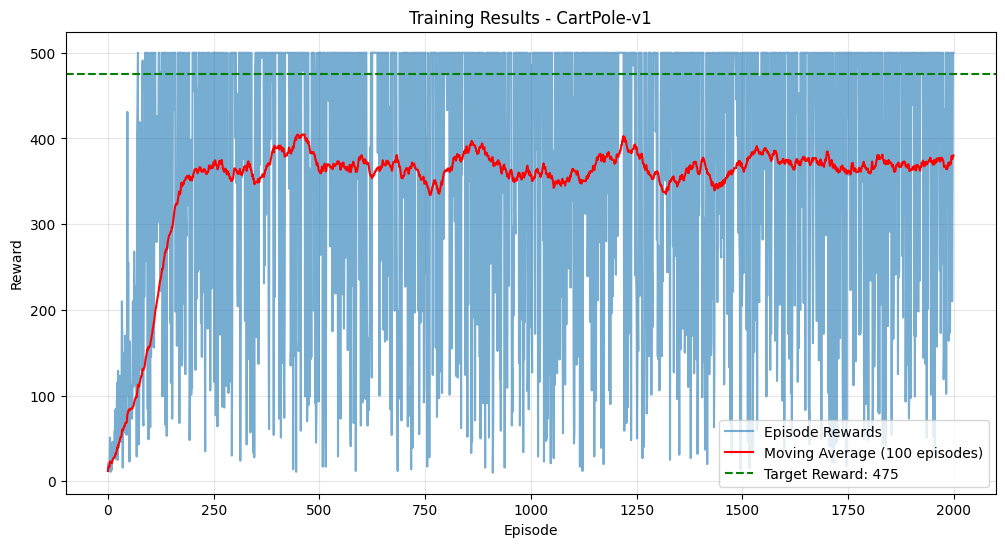


Evaluation over 10 episodes: 500.00


In [22]:
envs = ["CartPole-v1"]

for env_name in envs:
    print(f"\n{'='*50}")
    print(f"Training on {env_name}")
    print(f"{'='*50}")

    env = gym.make(env_name)
    config = env_configs[env_name]

    torch.manual_seed(42)
    np.random.seed(42)
    env.action_space.seed(42)

    if isinstance(env.action_space, gym.spaces.Discrete):
        output_dim = env.action_space.n
    else:
        output_dim = env.action_space.shape[0]

    actor = Actor(
        input_dim=env.observation_space.shape[0],
        output_dim=output_dim,
        action_space=env.action_space,
        hidden_dim=128
    ).to(device)

    critic = Critic(
        input_dim=env.observation_space.shape[0],
        hidden_dim=128
    ).to(device)

    agent = PPO(
        env=env,
        actor=actor,
        critic=critic,
        gamma=config["gamma"],
        lam=config["lam"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        update_epochs=config["update_epochs"],
        epsilon=config["epsilon"],
        entropy_coef=config["entropy_coef"]
    )

    rewards, avg_rewards = agent.train(
        num_episodes=config["num_episodes"],
        max_timesteps_per_episode=config["max_timesteps_per_episode"],
        target_reward=config["target_reward"]
    )

    plot_training_results(
        rewards,
        avg_rewards,
        env_name,
        target_reward=config["target_reward"]
    )

    evaluate_agent(env, actor, num_episodes=10)

    env.close()


Training on Acrobot-v1
Episode 10/1000 | Reward: -451.00 | Avg Reward: -495.10
Episode 20/1000 | Reward: -500.00 | Avg Reward: -495.90
Episode 30/1000 | Reward: -500.00 | Avg Reward: -497.27
Episode 40/1000 | Reward: -500.00 | Avg Reward: -492.80
Episode 50/1000 | Reward: -133.00 | Avg Reward: -444.02
Actor Loss: -0.0012 | Critic Loss: 33.1103 | Entropy: 0.4338 | Approx KL: 0.0141
Episode 60/1000 | Reward: -99.00 | Avg Reward: -393.78


<ipython-input-22-93150f91b13c>:236: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, mb_returns)


Episode 70/1000 | Reward: -97.00 | Avg Reward: -354.80
Episode 80/1000 | Reward: -77.00 | Avg Reward: -321.14
Episode 90/1000 | Reward: -64.00 | Avg Reward: -295.70
Episode 100/1000 | Reward: -71.00 | Avg Reward: -274.51
Actor Loss: -0.0556 | Critic Loss: 17.1468 | Entropy: 0.2281 | Approx KL: 0.0044
Episode 110/1000 | Reward: -80.00 | Avg Reward: -233.47
Episode 120/1000 | Reward: -63.00 | Avg Reward: -191.26
Episode 130/1000 | Reward: -76.00 | Avg Reward: -149.63
Episode 140/1000 | Reward: -78.00 | Avg Reward: -110.15

🎉 Environment solved in 144 episodes! Average reward: -99.72
Episode 150/1000 | Reward: -76.00 | Avg Reward: -93.26
Actor Loss: -0.0402 | Critic Loss: 13.6593 | Entropy: 0.0671 | Approx KL: 0.0017
Episode 160/1000 | Reward: -79.00 | Avg Reward: -88.86
Episode 170/1000 | Reward: -82.00 | Avg Reward: -85.18
Episode 180/1000 | Reward: -98.00 | Avg Reward: -84.83
Episode 190/1000 | Reward: -92.00 | Avg Reward: -86.36
Episode 200/1000 | Reward: -97.00 | Avg Reward: -86.08
A

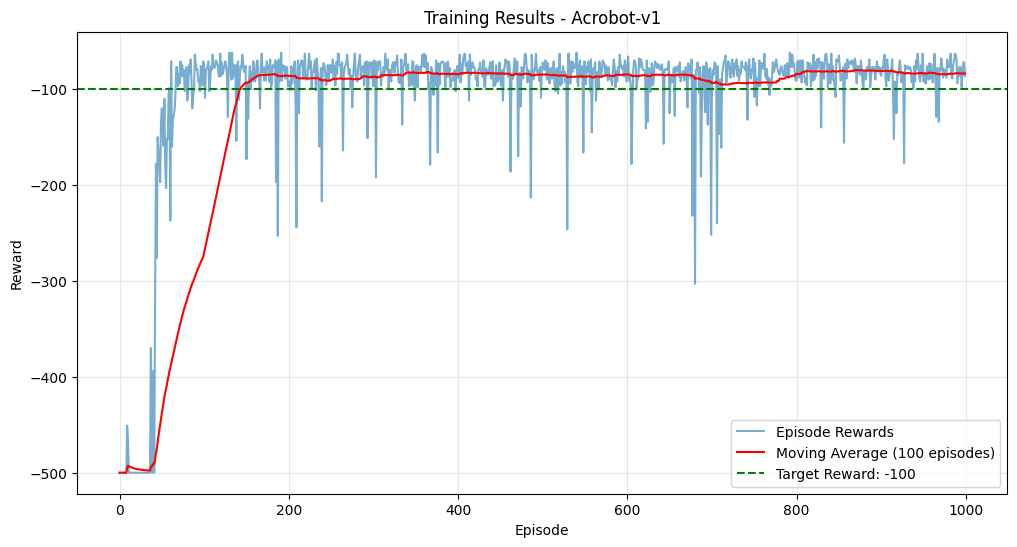


Evaluation over 10 episodes: -81.10


In [23]:
envs = ["Acrobot-v1"]

for env_name in envs:
    print(f"\n{'='*50}")
    print(f"Training on {env_name}")
    print(f"{'='*50}")

    env = gym.make(env_name)
    config = env_configs[env_name]

    torch.manual_seed(42)
    np.random.seed(42)
    env.action_space.seed(42)

    if isinstance(env.action_space, gym.spaces.Discrete):
        output_dim = env.action_space.n
    else:
        output_dim = env.action_space.shape[0]

    actor = Actor(
        input_dim=env.observation_space.shape[0],
        output_dim=output_dim,
        action_space=env.action_space,
        hidden_dim=128
    ).to(device)

    critic = Critic(
        input_dim=env.observation_space.shape[0],
        hidden_dim=128
    ).to(device)

    agent = PPO(
        env=env,
        actor=actor,
        critic=critic,
        gamma=config["gamma"],
        lam=config["lam"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        update_epochs=config["update_epochs"],
        epsilon=config["epsilon"],
        entropy_coef=config["entropy_coef"]
    )

    rewards, avg_rewards = agent.train(
        num_episodes=config["num_episodes"],
        max_timesteps_per_episode=config["max_timesteps_per_episode"],
        target_reward=config["target_reward"]
    )

    plot_training_results(
        rewards,
        avg_rewards,
        env_name,
        target_reward=config["target_reward"]
    )

    evaluate_agent(env, actor, num_episodes=10)

    env.close()


Training on BipedalWalker-v3


<ipython-input-5-871a96a2e705>:189: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states).to(device)


Episode 10/2000 | Reward: -117.34 | Avg Reward: -108.54
Episode 20/2000 | Reward: -112.49 | Avg Reward: -110.77
Episode 30/2000 | Reward: -117.90 | Avg Reward: -112.32
Episode 40/2000 | Reward: -110.12 | Avg Reward: -113.02


<ipython-input-5-871a96a2e705>:236: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(values, mb_returns)


Episode 50/2000 | Reward: -107.54 | Avg Reward: -112.75
Actor Loss: -0.0262 | Critic Loss: 805.3488 | Entropy: 5.6163 | Approx KL: 0.0015
Episode 60/2000 | Reward: -135.12 | Avg Reward: -113.55
Episode 70/2000 | Reward: -108.73 | Avg Reward: -112.34
Episode 80/2000 | Reward: -117.41 | Avg Reward: -111.64
Episode 90/2000 | Reward: -65.64 | Avg Reward: -107.86
Episode 100/2000 | Reward: -27.07 | Avg Reward: -104.33
Actor Loss: -0.0791 | Critic Loss: 0.2043 | Entropy: 5.5797 | Approx KL: 0.0152
Episode 110/2000 | Reward: 1.45 | Avg Reward: -94.72
Episode 120/2000 | Reward: 34.23 | Avg Reward: -88.36
Episode 130/2000 | Reward: -107.85 | Avg Reward: -78.73
Episode 140/2000 | Reward: 41.42 | Avg Reward: -69.47
Episode 150/2000 | Reward: -115.87 | Avg Reward: -63.98
Actor Loss: -0.0494 | Critic Loss: 74.6184 | Entropy: 5.3489 | Approx KL: 0.0220
Episode 160/2000 | Reward: 82.02 | Avg Reward: -49.43
Episode 170/2000 | Reward: 108.09 | Avg Reward: -31.76
Episode 180/2000 | Reward: 111.75 | Avg 

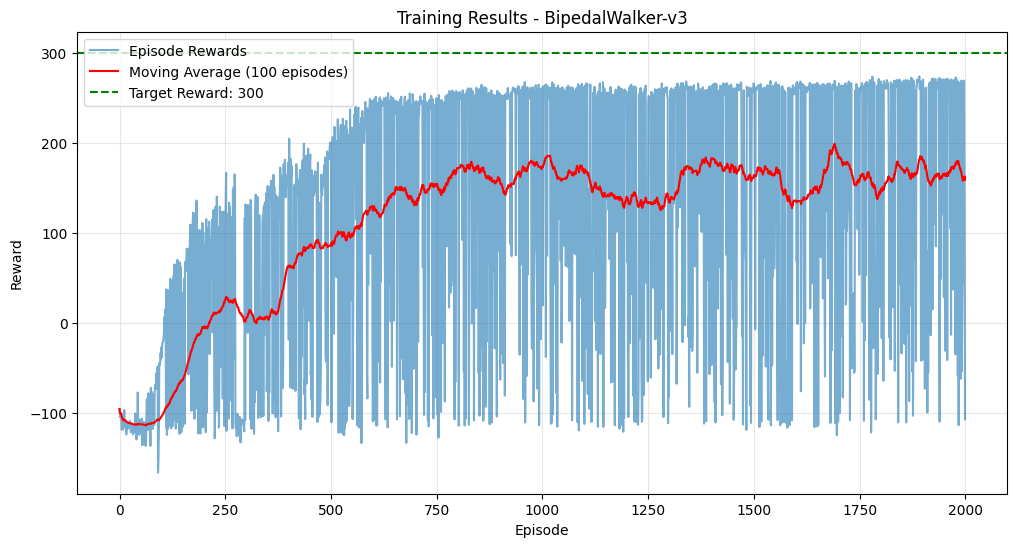


Evaluation over 10 episodes: 194.87


In [6]:
envs = ["BipedalWalker-v3"]

for env_name in envs:
    print(f"\n{'='*50}")
    print(f"Training on {env_name}")
    print(f"{'='*50}")

    env = gym.make(env_name)
    config = env_configs[env_name]

    torch.manual_seed(42)
    np.random.seed(42)
    env.action_space.seed(42)

    if isinstance(env.action_space, gym.spaces.Discrete):
        output_dim = env.action_space.n
    else:
        output_dim = env.action_space.shape[0]

    actor = Actor(
        input_dim=env.observation_space.shape[0],
        output_dim=output_dim,
        action_space=env.action_space,
        hidden_dim=128
    ).to(device)

    critic = Critic(
        input_dim=env.observation_space.shape[0],
        hidden_dim=128
    ).to(device)

    agent = PPO(
        env=env,
        actor=actor,
        critic=critic,
        gamma=config["gamma"],
        lam=config["lam"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        update_epochs=config["update_epochs"],
        epsilon=config["epsilon"],
        entropy_coef=config["entropy_coef"]
    )

    rewards, avg_rewards = agent.train(
        num_episodes=config["num_episodes"],
        max_timesteps_per_episode=config["max_timesteps_per_episode"],
        target_reward=config["target_reward"]
    )

    plot_training_results(
        rewards,
        avg_rewards,
        env_name,
        target_reward=config["target_reward"]
    )

    evaluate_agent(env, actor, num_episodes=10)

    env.close()